In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import openpyxl
import os
import glob

# PM2.5 data processing

In [3]:
data_directory = r'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/Yang et al dataset/data & code for Zenodo/data_main_HY/Health calculations/2020-02-24 (geospatial processing data)/spatial_join_pm_pop/'
match_file_path = r'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/Country Match/yang_pm25_country_match.xlsx'
new_save_directory = r'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_calculated/'

os.makedirs(new_save_directory, exist_ok=True)

yang_pm25_country_match = pd.read_excel(match_file_path)

file_pattern = os.path.join(data_directory, 'world_pop_pm_ssp*.csv')
file_list = glob.glob(file_pattern)

def process_file(file_path, match_df):

    df = pd.read_csv(file_path)

    df.drop(df[(df['SUM_pop'] == 0.0)].index,inplace=True)

    df = df.merge(match_df, on=['Country', 'COUNTRYAFF', 'STATE_NAME', 'NAME'], how='left')

    df['STATE_NAME'] = df['STATE_NAME'].replace(['Hong Kong', 'Taiwan'], np.nan)

    df = df[df['STATE_NAME'].isna()].drop(columns=['STATE_NAME']).reset_index(drop=True)

    return df

ssp_dict = {}

for file_path in file_list:
    processed_df = process_file(file_path, yang_pm25_country_match)
    
    filename = os.path.basename(file_path)
    
    parts = filename.split('_')
    ssp = parts[3]
    year = parts[4].split('.')[0] 

    processed_df['Year'] = year

    if ssp not in ssp_dict:
        ssp_dict[ssp] = []
    ssp_dict[ssp].append(processed_df)

for ssp, df_list in ssp_dict.items():
    concatenated_df = pd.concat(df_list, ignore_index=True)
    
    output_file_path = os.path.join(new_save_directory, f'world_pop_pm_{ssp}_processed.csv')
    
    concatenated_df.to_csv(output_file_path, index=False)

print("All files processed successfully.")

All files processed successfully.


In [4]:
processed_files_path = '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_calculated/'

ssp_scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370']

interpolated_df = pd.DataFrame()

for ssp_scenario in ssp_scenarios:

    file_pattern = processed_files_path + f'world_pop_pm_{ssp_scenario}_processed.csv'
    
    file_list = glob.glob(file_pattern)

    for file_path in file_list:
        world_pop_pm_processed = pd.read_csv(file_path)

        world_pop_pm_processed['Year'] = pd.to_numeric(world_pop_pm_processed['Year'])

        target_years = list(range(2020, 2100, 10))

        grouped = world_pop_pm_processed.groupby('iso_code')

        interpolated_file_df = pd.DataFrame()

        for iso_code, group in grouped:

            group.set_index('Year', inplace=True)

            group = group.reindex(group.index.union(target_years)).sort_index()

            group['pm2p5'] = group['pm2p5'].interpolate(method='linear')

            interpolated_group = group.loc[target_years].reset_index()
            interpolated_group['iso_code'] = iso_code

            for col in ['Country', 'COUNTRYAFF', 'NAME', 'SUM_pop']:
                interpolated_group[col] = group[col].iloc[0]

            interpolated_file_df = pd.concat([interpolated_file_df, interpolated_group], ignore_index=True)

        interpolated_df = pd.concat([world_pop_pm_processed, interpolated_file_df], ignore_index=True).sort_values(by=['iso_code','Year'])

    interpolated_file_path = f'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated/interpolated_world_pop_pm_{ssp_scenario}.csv'
    interpolated_df.to_csv(interpolated_file_path, index=False)


In [5]:
interpolated_data_path = '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated/'
output_data_path = '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated (2020 unified)/'

ssp_scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370']

interpolated_world_pop_pm_ssp245 = pd.read_csv(r'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated/interpolated_world_pop_pm_ssp245.csv')

PM_2020_ssp245 = interpolated_world_pop_pm_ssp245[interpolated_world_pop_pm_ssp245['Year']==2020][['Country', 'COUNTRYAFF', 'NAME', 'pm2p5', 'iso_code','Year']]

for ssp_scenario in ssp_scenarios:

    interpolated_file_path = f'{interpolated_data_path}interpolated_world_pop_pm_{ssp_scenario}.csv'
    interpolated_df = pd.read_csv(interpolated_file_path)

    filtered_df = interpolated_df[interpolated_df['Year'] != 2020][['Country', 'COUNTRYAFF', 'NAME', 'pm2p5', 'iso_code','Year']]

    combined_df = pd.concat([filtered_df, PM_2020_ssp245], ignore_index=True).sort_values(by=['iso_code', 'Year']).reset_index(drop=True)
    
    output_file_path = f'{output_data_path}interpolated_world_pm_{ssp_scenario}_2020_unified_ssp245.csv'
    combined_df.to_csv(output_file_path, index=False)
    
    variable_name = f'interpolated_world_pm_{ssp_scenario}_2020_unified_ssp245'
    globals()[variable_name] = combined_df

    print(f"Processed and saved: {output_file_path}")

Processed and saved: /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated (2020 unified)/interpolated_world_pm_ssp119_2020_unified_ssp245.csv
Processed and saved: /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated (2020 unified)/interpolated_world_pm_ssp126_2020_unified_ssp245.csv
Processed and saved: /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated (2020 unified)/interpolated_world_pm_ssp245_2020_unified_ssp245.csv
Processed and saved: /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated (2020 unified)/interpolated_world_pm_ssp370_2020_unified_ssp

# Figure S - PM2.5 concentration

In [78]:
wcde_country_code = pd.read_excel(r'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/Country Match/country_code.xlsx')

wcde_country_code

,Area,iso_code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Angola,AGO
4,Antigua and Barbuda,ATG
...,...,...
196,Western Sahara,ESH
197,World,WLD
198,Yemen,YEM
199,Zambia,ZMB


In [79]:
pop = pd.read_csv(f'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/SSP datasets/Population/wcde_data_v3.csv',skiprows=8)

pop = pop[(pop['Age']!='All')&(pop['Sex']!='Both')]

pop = pop.merge(wcde_country_code,on=['Area'],how='left')

pop['age'] = pop['Age'].str.extract(r'(\d+)', expand=False).astype(int)

pop['sex'] = pop['Sex'].replace({'Male':'m','Female':'f'})

pop['SSPs'] = pop['Scenario']

pop=pop[['SSPs',  'Year',  'sex', 'Population', 'iso_code', 'age']]

pop

,SSPs,Year,sex,Population,iso_code,age
0,SSP2,2020,m,3231.9,AFG,0
1,SSP2,2025,m,3527.3,AFG,0
2,SSP2,2030,m,3773.0,AFG,0
3,SSP2,2035,m,3943.3,AFG,0
4,SSP2,2040,m,4075.3,AFG,0
...,...,...,...,...,...,...
717565,SSP5,2080,f,8.3,ZWE,100
717566,SSP5,2085,f,15.4,ZWE,100
717567,SSP5,2090,f,22.0,ZWE,100
717568,SSP5,2095,f,31.3,ZWE,100


In [ ]:
#pop.to_csv(f'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/SSP datasets/Population/pop.csv',index=False)

In [80]:
pop_all = pop.groupby(['SSPs', 'Year', 'iso_code'])['Population'].sum().reset_index()
pop_all

,SSPs,Year,iso_code,Population
0,SSP1,2020,ABW,106.5
1,SSP1,2020,AFG,38325.9
2,SSP1,2020,AGO,32899.1
3,SSP1,2020,ALB,2872.0
4,SSP1,2020,ARE,9247.3
...,...,...,...,...
17080,SSP5,2100,WSM,137.2
17081,SSP5,2100,YEM,45805.3
17082,SSP5,2100,ZAF,54126.7
17083,SSP5,2100,ZMB,35344.0


In [81]:
interpolated_world_pm_ssp119_2020_unified_ssp245_pop = interpolated_world_pm_ssp119_2020_unified_ssp245.merge(pop_all[pop_all['SSPs']=='SSP1'], on=[ 'Year', 'iso_code'], how='left').dropna(subset=['Population'])

pop_pm25_ssp119_grouped = interpolated_world_pm_ssp119_2020_unified_ssp245_pop.groupby(by='Year').apply(
    lambda group: pd.Series({
        'pop_weighted_pm2p5': (group['pm2p5'] * group['Population']).sum() / group['Population'].sum(),
    })
).reset_index()

interpolated_world_pm_ssp126_2020_unified_ssp245_pop = interpolated_world_pm_ssp126_2020_unified_ssp245.merge(pop_all[pop_all['SSPs']=='SSP1'], on=[ 'Year', 'iso_code'], how='left').dropna(subset=['Population'])

pop_pm25_ssp126_grouped = interpolated_world_pm_ssp126_2020_unified_ssp245_pop.groupby(by='Year').apply(
    lambda group: pd.Series({
        'pop_weighted_pm2p5': (group['pm2p5'] * group['Population']).sum() / group['Population'].sum(),
    })
).reset_index()

interpolated_world_pm_ssp245_2020_unified_ssp245_pop = interpolated_world_pm_ssp245_2020_unified_ssp245.merge(pop_all[pop_all['SSPs']=='SSP2'], on=[ 'Year', 'iso_code'], how='left').dropna(subset=['Population'])

pop_pm25_ssp245_grouped = interpolated_world_pm_ssp245_2020_unified_ssp245_pop.groupby(by='Year').apply(
    lambda group: pd.Series({
        'pop_weighted_pm2p5': (group['pm2p5'] * group['Population']).sum() / group['Population'].sum(),
    })
).reset_index()

interpolated_world_pm_ssp370_2020_unified_ssp370_pop = interpolated_world_pm_ssp370_2020_unified_ssp245.merge(pop_all[pop_all['SSPs']=='SSP3'], on=[ 'Year', 'iso_code'], how='left').dropna(subset=['Population'])

pop_pm25_ssp370_grouped = interpolated_world_pm_ssp370_2020_unified_ssp370_pop.groupby(by='Year').apply(
    lambda group: pd.Series({
        'pop_weighted_pm2p5': (group['pm2p5'] * group['Population']).sum() / group['Population'].sum(),
    })
).reset_index()


/var/folders/w_/v7dhjtc519b5xkcdsf_td1480000gp/T/ipykernel_32459/2287719939.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pop_pm25_ssp119_grouped = interpolated_world_pm_ssp119_2020_unified_ssp245_pop.groupby(by='Year').apply(
/var/folders/w_/v7dhjtc519b5xkcdsf_td1480000gp/T/ipykernel_32459/2287719939.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pop_pm25_ssp126_grouped = interpolated_world_pm_

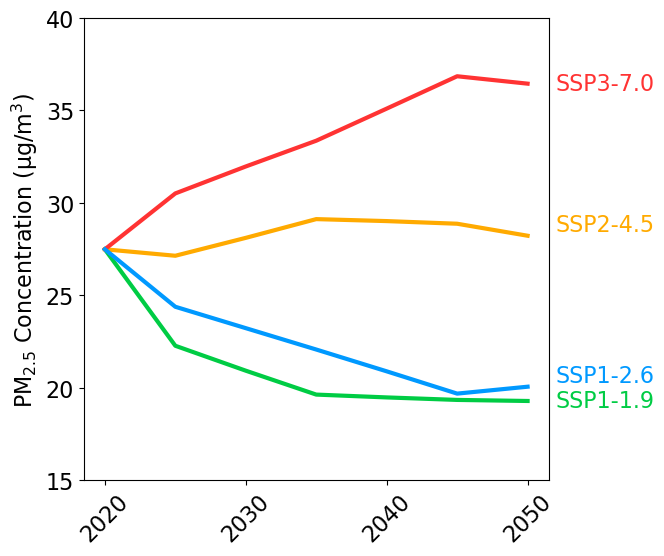

In [82]:
years_to_plot = np.arange(2020, 2101, 10)

dfs = {
    'SSP1-1.9': pop_pm25_ssp119_grouped,
    'SSP2-4.5': pop_pm25_ssp245_grouped,
    'SSP3-7.0': pop_pm25_ssp370_grouped,
    'SSP1-2.6': pop_pm25_ssp126_grouped

}

colors = {
    'SSP1-1.9': '#00CC44', 
    'SSP1-2.6': '#0099FF',
    'SSP2-4.5': '#FFAA00',
    'SSP3-7.0': '#FF3333'

}

plt.figure(figsize=(6, 6))

for scenario, df in dfs.items():

    df_solid = df[(df['Year'] >= 2020) & (df['Year'] <= 2050)]
    
    line_width = 3 
    alpha = 1 
    
    plt.plot(df_solid['Year'], df_solid['pop_weighted_pm2p5'], 
             label=scenario, linestyle='-', linewidth=line_width, alpha=alpha, color=colors[scenario])
    
    last_year_solid = df_solid['Year'].iloc[-1]
    last_value_solid = df_solid['pop_weighted_pm2p5'].iloc[-1]
    

    y_offset = 0.6 if scenario in ['SSP1-2.6'] else (0.6 if scenario=='SSP2-4.5' else 0 )
    
    plt.text(2052, last_value_solid + y_offset, 
             scenario, color=colors[scenario], fontsize=16, ha='left', va='center', alpha=alpha)


plt.xticks(np.arange(2020, 2051, 10), fontsize=16,rotation=45)
plt.yticks(np.arange(15, 41, 5), fontsize=16)

plt.ylabel('PM$_{2.5}$ Concentration (µg/m$^{3}$)', fontsize=16)

plt.tick_params(axis='y', labelsize=16)

plt.show()

# Relative Risk(RR) & Attributable Fraction(AF) Estimates 

In [11]:
def process_relative_risk(RR_disease_GBD2021_draws):

    RR_disease_GBD2021 = RR_disease_GBD2021_draws.copy()

    new_columns = {}
    
    for i in range(1, 1001):
  
        new_column = RR_disease_GBD2021[f'draw_{i}'].copy()
        
        tmrel = np.round(np.random.uniform(2.4, 5.9), decimals=1)
        
        MRBRT_value = RR_disease_GBD2021[RR_disease_GBD2021['exposure'] == tmrel][f'draw_{i}'].values[0]
        
        new_column[RR_disease_GBD2021['exposure'] >= tmrel] = (
            new_column[RR_disease_GBD2021['exposure'] >= tmrel] / MRBRT_value
        )
        new_column[RR_disease_GBD2021['exposure'] < tmrel] = 1
        
        new_columns[f'RR_draw_{i}'] = new_column
    
    RR_disease_GBD2021 = pd.concat([RR_disease_GBD2021, pd.DataFrame(new_columns, index=RR_disease_GBD2021.index)], axis=1)
    
    rr_draw_columns = [col for col in RR_disease_GBD2021.columns if col.startswith('RR_draw_')]
    
    RR_disease_GBD2021['RR_AVG'] = RR_disease_GBD2021[rr_draw_columns].mean(axis=1)
    RR_disease_GBD2021['RR_LOW'] = RR_disease_GBD2021[rr_draw_columns].quantile(0.025, axis=1)
    RR_disease_GBD2021['RR_HIGH'] = RR_disease_GBD2021[rr_draw_columns].quantile(0.975, axis=1)
    
    RR_disease_GBD2021 = RR_disease_GBD2021[['cause', 'exposure', 'RR_AVG', 'RR_LOW', 'RR_HIGH']]
    
    exposure_above_10 = RR_disease_GBD2021[RR_disease_GBD2021['exposure'] >= 10].copy()
    
    new_exposure_levels = np.arange(10, exposure_above_10['exposure'].max() + 0.1, 0.1)
    
    interpolated_df = pd.DataFrame({
        'cause': RR_disease_GBD2021['cause'].values[0],
        'exposure': new_exposure_levels,
        'RR_AVG': np.interp(new_exposure_levels, exposure_above_10['exposure'], exposure_above_10['RR_AVG']),
        'RR_LOW': np.interp(new_exposure_levels, exposure_above_10['exposure'], exposure_above_10['RR_LOW']),
        'RR_HIGH': np.interp(new_exposure_levels, exposure_above_10['exposure'], exposure_above_10['RR_HIGH']),
    })
    
    exposure_below_10 = RR_disease_GBD2021[RR_disease_GBD2021['exposure'] < 10].copy()
    
    RR_disease_GBD2021 = pd.concat([exposure_below_10, interpolated_df], ignore_index=True)
    
    RR_disease_GBD2021 = RR_disease_GBD2021.sort_values(by='exposure').reset_index(drop=True)
    
    RR_disease_GBD2021 = RR_disease_GBD2021[['cause', 'exposure', 'RR_AVG', 'RR_LOW', 'RR_HIGH']]
    
    return RR_disease_GBD2021

file_paths = {
    'COP': '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Air Pollution Exposure Estimates 1990-2021/IHME_GBD_2021_AIR_POLLUTION_1990_2021_RR_CURVES/IHME_GBD_2021_AIR_POLLUTION_1990_2021_PM_RR_COPD_DRAWS_Y2022M01D31.CSV',
    'LRI': '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Air Pollution Exposure Estimates 1990-2021/IHME_GBD_2021_AIR_POLLUTION_1990_2021_RR_CURVES/IHME_GBD_2021_AIR_POLLUTION_1990_2021_PM_RR_LOWER_RESPIRATORY_INFECTIONS_DRAWS_Y2022M01D31.CSV',
    'IHD': '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Air Pollution Exposure Estimates 1990-2021/IHME_GBD_2021_AIR_POLLUTION_1990_2021_RR_CURVES/IHME_GBD_2021_AIR_POLLUTION_1990_2021_PM_RR_ISCHEMIC_HEART_DISEASE_DRAWS_Y2022M01D31.CSV',
    'TDM': '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Air Pollution Exposure Estimates 1990-2021/IHME_GBD_2021_AIR_POLLUTION_1990_2021_RR_CURVES/IHME_GBD_2021_AIR_POLLUTION_1990_2021_PM_RR_DIABETES_DRAWS_Y2022M01D31.CSV',
    'LUN': '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Air Pollution Exposure Estimates 1990-2021/IHME_GBD_2021_AIR_POLLUTION_1990_2021_RR_CURVES/IHME_GBD_2021_AIR_POLLUTION_1990_2021_PM_RR_LUNG_CANCER_DRAWS_Y2022M01D31.CSV',
    'STR': '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Air Pollution Exposure Estimates 1990-2021/IHME_GBD_2021_AIR_POLLUTION_1990_2021_RR_CURVES/IHME_GBD_2021_AIR_POLLUTION_1990_2021_PM_RR_STROKE_DRAWS_Y2022M01D31.CSV'
}

processed_datasets = {}
for dataset_name, file_path in file_paths.items():

    draws_df = pd.read_csv(file_path)
    
    processed_df = process_relative_risk(draws_df)

    processed_datasets[dataset_name] = processed_df

output_dir = '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Relative Risk Estimates/'
for dataset_name, processed_df in processed_datasets.items():
    output_path = f"{output_dir}RR_{dataset_name}_GBD2021.csv"
    processed_df.to_csv(output_path, index=False)
    print(f"Saved {dataset_name} to {output_path}")


Saved COP to /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Relative Risk Estimates/RR_COP_GBD2021.csv
Saved LRI to /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Relative Risk Estimates/RR_LRI_GBD2021.csv
Saved IHD to /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Relative Risk Estimates/RR_IHD_GBD2021.csv
Saved TDM to /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Relative Risk Estimates/RR_TDM_GBD2021.csv
Saved LUN to /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Relative Risk Estimates/RR_LUN_GBD2021.csv
Saved STR to /Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and da

In [12]:
RR_COP_GBD2021 = processed_datasets['COP']
RR_LRI_GBD2021 = processed_datasets['LRI']
RR_IHD_GBD2021 = processed_datasets['IHD']
RR_TDM_GBD2021 = processed_datasets['TDM']
RR_LUN_GBD2021 = processed_datasets['LUN']
RR_STR_GBD2021 = processed_datasets['STR']

# Figure S - RR curves

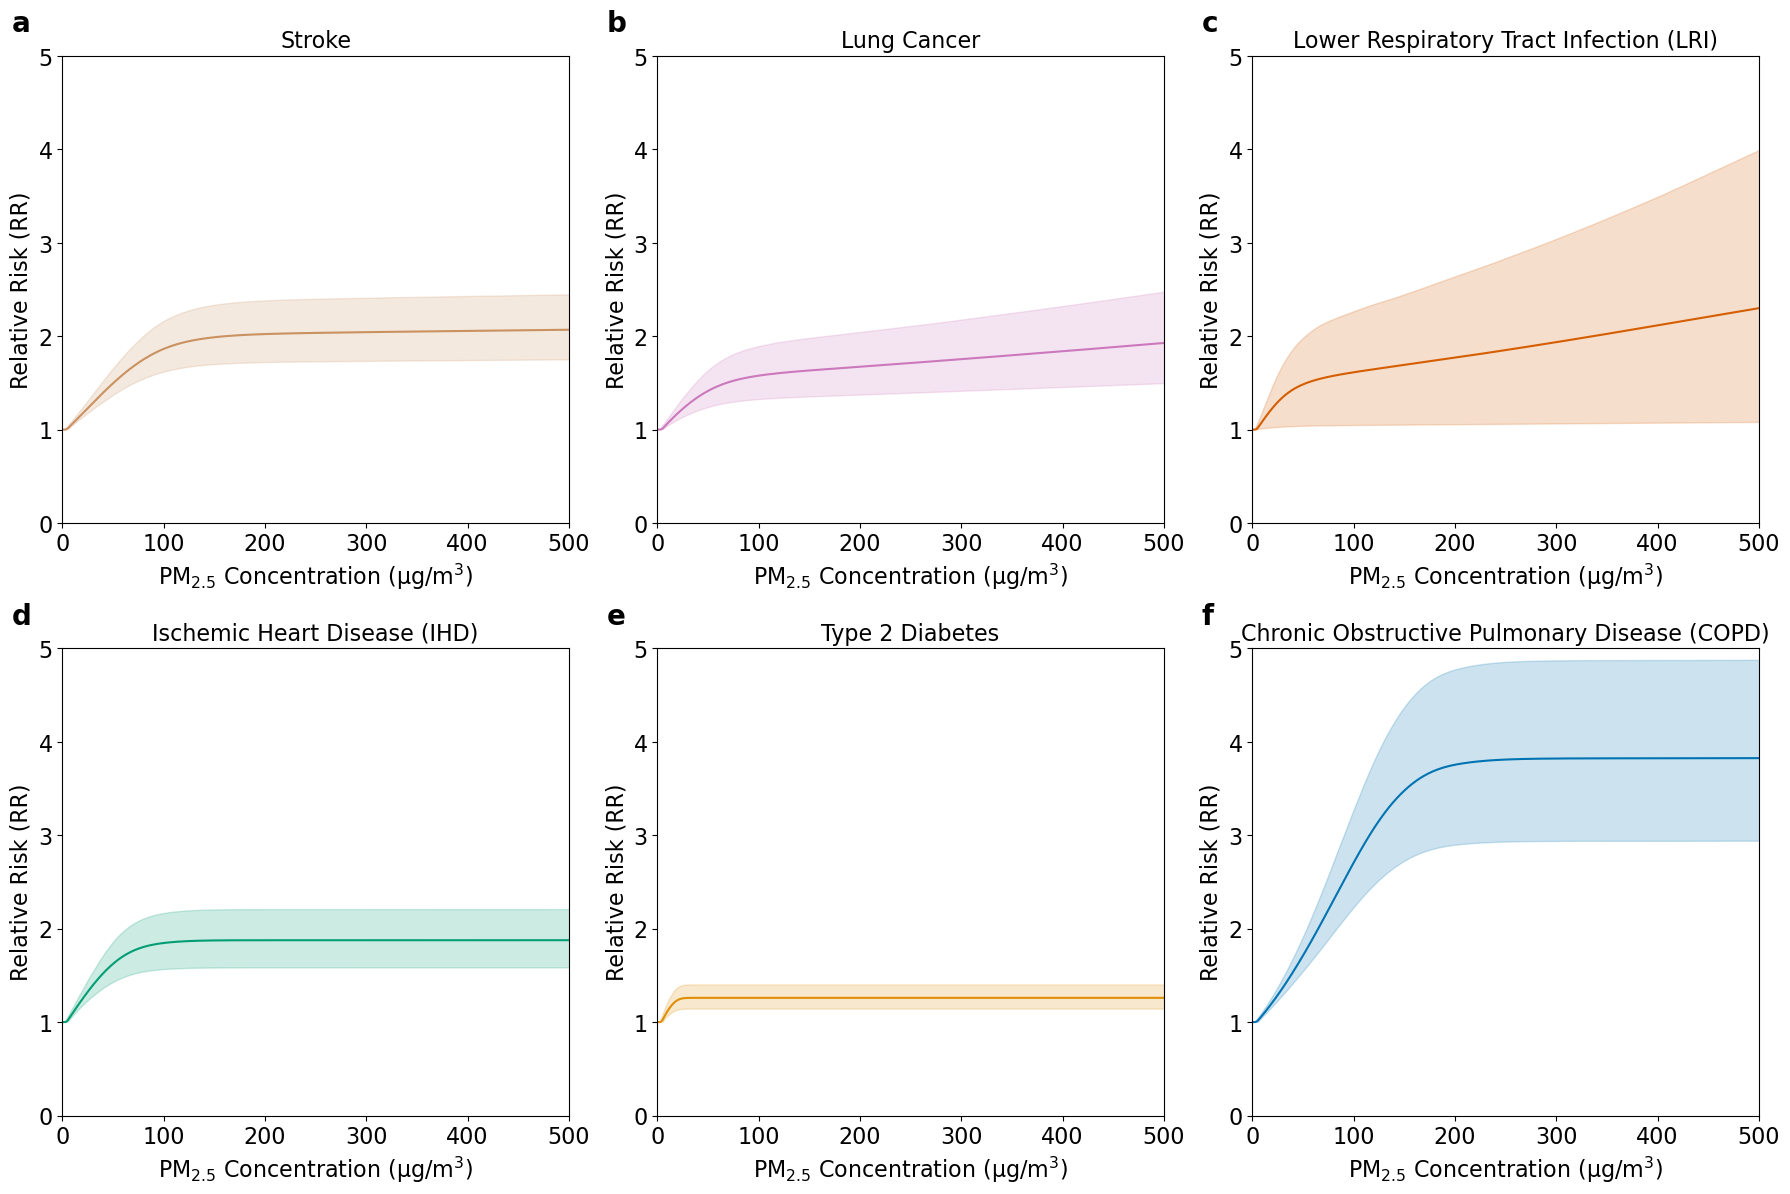

In [108]:

datasets = {
    "STR": (RR_STR_GBD2021, "Stroke", "#ca9161"),
    "LUN": (RR_LUN_GBD2021, "Lung Cancer", "#cc78bc"),
    "LRI": (RR_LRI_GBD2021, "Lower Respiratory Tract Infection (LRI)", "#d55e00"),
    "IHD": (RR_IHD_GBD2021, "Ischemic Heart Disease (IHD)", "#029e73"),
    "TDM": (RR_TDM_GBD2021, "Type 2 Diabetes", "#de8f05"),
    "COP": (RR_COP_GBD2021, "Chronic Obstructive Pulmonary Disease (COPD)", "#0173b2")
}


subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f']


fig, axs = plt.subplots(2, 3, figsize=(18, 12))


for ax, (label, (df, title, color)), subplot_label in zip(axs.flat, datasets.items(), subplot_labels):
    ax.plot(df['exposure'], df['RR_AVG'], label=label, color=color)
    ax.fill_between(df['exposure'], df['RR_LOW'], df['RR_HIGH'], color=color, alpha=0.2)
    ax.set_title(title, fontsize=16)
    ax.set_ylim([0, 5])
    ax.set_xlim([0, 500])
    ax.set_xlabel('PM$_{2.5}$ Concentration (µg/m$^{3}$)', fontsize=16)
    ax.set_ylabel('Relative Risk (RR)', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.text(-0.1, 1.1, f"{subplot_label}", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top')

plt.tight_layout()
plt.show()


# Figure S - Trend for share of six PM2.5-related diseases to total death  

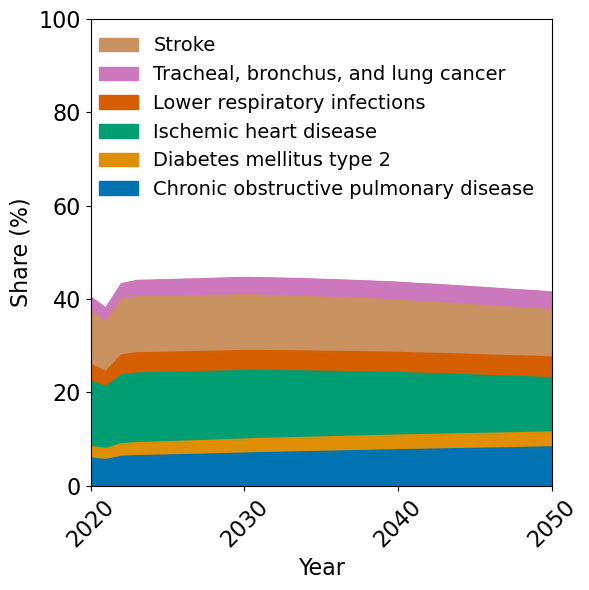

In [55]:

data_dir = "/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Foresight/share_of_diseases/Global Trend"

datasets = {
    "STR": ("Stroke", "#ca9161"),
    "LUN": ("Tracheal, bronchus, and lung cancer", "#cc78bc"),
    "LRI": ("Lower respiratory infections", "#d55e00"),
    "IHD": ("Ischemic heart disease", "#029e73"),
    "TDM": ("Diabetes mellitus type 2", "#de8f05"),
    "COP": ("Chronic obstructive pulmonary disease", "#0173b2")
}

name_to_color = {
    "Stroke": "#ca9161",
    "Tracheal, bronchus, and lung cancer": "#cc78bc",
    "Lower respiratory infections": "#d55e00",
    "Ischemic heart disease": "#029e73",
    "Diabetes mellitus type 2": "#de8f05",
    "Chronic obstructive pulmonary disease": "#0173b2"
}

df_list = []
for disease_code, (disease_name, _) in datasets.items():
    file_path = os.path.join(data_dir, f"{disease_code}.csv")
    df = pd.read_csv(file_path)
    df["Disease"] = disease_name
    df_list.append(df)

df_combined = pd.concat(df_list, ignore_index=True)

pivot_df = df_combined.pivot_table(
    index="Year", 
    columns="Cause of death or injury", 
    values="Value", 
    aggfunc="mean" 
).fillna(0)*100

color_palette = [name_to_color[disease] for disease in pivot_df.columns]

ax = pivot_df.plot(kind="area", stacked=True, figsize=(6, 6), color=color_palette)

plt.xlabel("Year", fontsize=16)
plt.ylabel("Share (%)", fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, 100)


plt.yticks(np.arange(0, 101, 20), fontsize=16)
plt.xlim(2020, 2050)
plt.xticks(np.arange(2020, 2051, 10), fontsize=16,rotation=45)

plt.grid(False)

handles, labels = ax.get_legend_handles_labels()
order = list(datasets.values()) 
order_dict = {name: handles[labels.index(name)] for name, _ in order if name in labels}
ax.legend(order_dict.values(), order_dict.keys(), title=None, bbox_to_anchor=(1, 1), loc="upper right", fontsize=14 ,frameon=False)

plt.tight_layout()
plt.show()


# Figure S - Trend of PM2.5&diseases

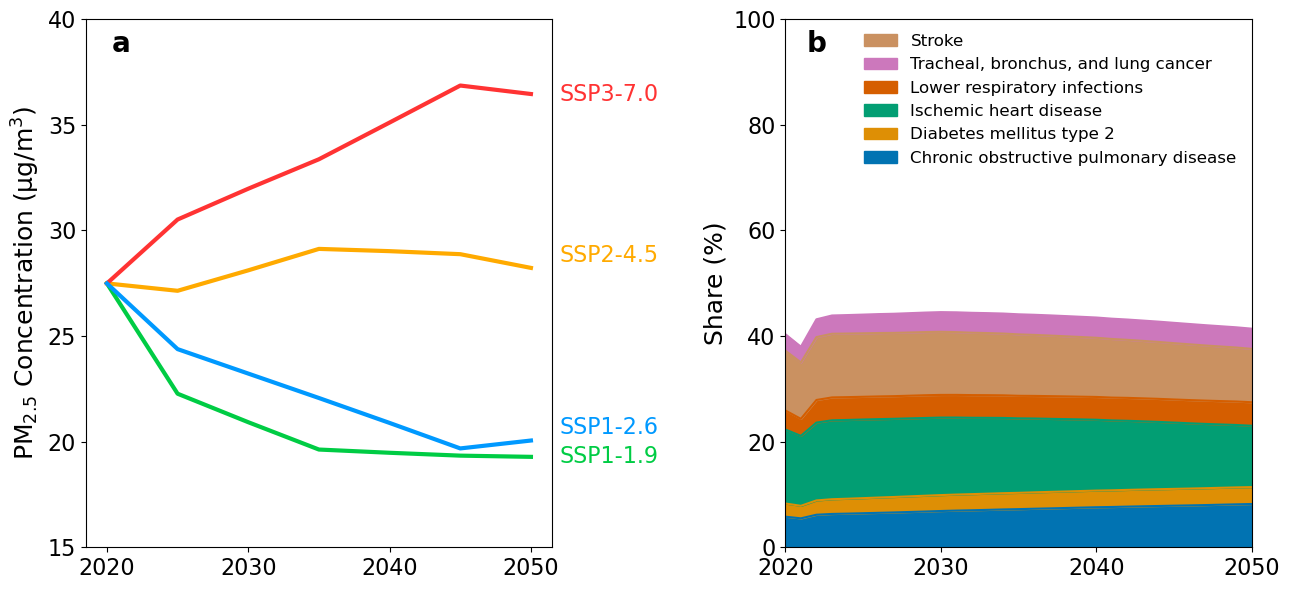

In [103]:
years_to_plot = np.arange(2020, 2101, 10)

dfs = {
    'SSP1-1.9': pop_pm25_ssp119_grouped,
    'SSP2-4.5': pop_pm25_ssp245_grouped,
    'SSP3-7.0': pop_pm25_ssp370_grouped,
    'SSP1-2.6': pop_pm25_ssp126_grouped
}

colors = {
    'SSP1-1.9': '#00CC44',
    'SSP1-2.6': '#0099FF',
    'SSP2-4.5': '#FFAA00',
    'SSP3-7.0': '#FF3333'
}

data_dir = "/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Foresight/share_of_diseases/Global Trend"

datasets = {
    "STR": ("Stroke", "#ca9161"),
    "LUN": ("Tracheal, bronchus, and lung cancer", "#cc78bc"),
    "LRI": ("Lower respiratory infections", "#d55e00"),
    "IHD": ("Ischemic heart disease", "#029e73"),
    "TDM": ("Diabetes mellitus type 2", "#de8f05"),
    "COP": ("Chronic obstructive pulmonary disease", "#0173b2")
}

name_to_color = {v[0]: v[1] for v in datasets.values()}

df_list = []
for disease_code, (disease_name, _) in datasets.items():
    file_path = os.path.join(data_dir, f"{disease_code}.csv")
    df = pd.read_csv(file_path)
    df["Disease"] = disease_name
    df_list.append(df)

df_combined = pd.concat(df_list, ignore_index=True)
pivot_df = df_combined.pivot_table(
    index="Year", 
    columns="Cause of death or injury", 
    values="Value", 
    aggfunc="mean"
).fillna(0) * 100  

color_palette = [name_to_color[disease] for disease in pivot_df.columns]

fig, axes = plt.subplots(1, 2, figsize=(13, 6)) 

ax1 = axes[0]

for scenario, df in dfs.items():
    df_solid = df[(df['Year'] >= 2020) & (df['Year'] <= 2050)]
    ax1.plot(df_solid['Year'], df_solid['pop_weighted_pm2p5'],
             label=scenario, linestyle='-', linewidth=3, alpha=1, color=colors[scenario])
    
    last_value = df_solid['pop_weighted_pm2p5'].iloc[-1]
    y_offset = 0.6 if scenario in ['SSP1-2.6', 'SSP2-4.5'] else 0
    ax1.text(2052, last_value + y_offset, scenario, color=colors[scenario], fontsize=16, ha='left', va='center')

ax1.set_ylabel('PM$_{2.5}$ Concentration (µg/m$^{3}$)', fontsize=18)
ax1.set_xticks(np.arange(2020, 2051, 10))
ax1.set_yticks(np.arange(15, 41, 5))
ax1.tick_params(axis='both', labelsize=16)
ax1.text(2021, 39.5, "a", fontsize=20, ha="center", va="top", fontweight='bold')

ax2 = axes[1]
pivot_df.plot(kind="area", stacked=True, color=color_palette, ax=ax2)

ax2.set_ylabel("Share (%)", fontsize=18)
ax2.set_xlim(2020, 2050)
ax2.set_ylim(0, 100)
ax2.set_xlabel("")
ax2.set_xticks(np.arange(2020, 2051, 10))
ax2.set_yticks(np.arange(0, 101, 20))
ax2.tick_params(axis='both', labelsize=16)
ax2.text(2022, 98, "b", fontsize=20, ha="center", va="top", fontweight='bold')
ax2.grid(False)

handles, labels = ax2.get_legend_handles_labels()
desired_order = [v[0] for v in datasets.values()]
ordered_handles = [handles[labels.index(name)] for name in desired_order]
ax2.legend(ordered_handles, desired_order, loc='upper right', fontsize=12, frameon=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)  
plt.show()

# Matching PM2.5 & RR and calculating AF 

In [19]:
def interpolate_rr(pm25_level_df, rr_df):

    interpolated_results = []
    
    pm2p5_values = pm25_level_df['pm2p5']

    for pm2p5 in pm2p5_values:

        if pm2p5 < rr_df['exposure'].min():

            rr_values = rr_df.iloc[0][['RR_AVG','RR_LOW','RR_HIGH']].to_dict()
        elif pm2p5 > rr_df['exposure'].max():

            rr_values = rr_df.iloc[-1][['RR_AVG','RR_LOW','RR_HIGH']].to_dict()
        else:

            lower_idx = rr_df[rr_df['exposure'] <= pm2p5]['exposure'].idxmax()
            upper_idx = rr_df[rr_df['exposure'] >= pm2p5]['exposure'].idxmin()

            lower_exposure = rr_df.loc[lower_idx, 'exposure']
            upper_exposure = rr_df.loc[upper_idx, 'exposure']

            rr_values = {}
            for col in ['RR_AVG','RR_LOW','RR_HIGH']:
                lower_rr = rr_df.loc[lower_idx, col]
                upper_rr = rr_df.loc[upper_idx, col]

                rr_values[col] = lower_rr + (pm2p5 - lower_exposure) * (upper_rr - lower_rr) / (upper_exposure - lower_exposure)

        rr_values['pm2p5'] = pm2p5
        interpolated_results.append(rr_values)

    pm25_level_df['cause']=rr_df['cause'].unique()[0]
    pm25_level_df = pm25_level_df.merge(pd.DataFrame(interpolated_results),on=['pm2p5',],how = 'left')

    for i in ['AVG', 'LOW', 'HIGH']:
        pm25_level_df[f'AF_{i}'] = 1 - (1 / pm25_level_df[f'RR_{i}'])

    return pm25_level_df

In [ ]:

interpolated_data_path  = '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/PM25 data/Air Pollution Data/PM25_interpolated (2020 unified)/'

RR2021_data_path = '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/Relative Risk Estimates/'

AF2021_data_path = '/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/PM25_RR_AF Estimates/'

scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370']

RR_dataframes = [RR_IHD_GBD2021, RR_STR_GBD2021, RR_LRI_GBD2021, RR_LUN_GBD2021, RR_TDM_GBD2021, RR_COP_GBD2021]

diseases_names = ['IHD', 'STR', 'LRI', 'LUN', 'TDM', 'COP']

for scenario in scenarios:

    interpolated_file_path = f'{interpolated_data_path}interpolated_world_pm_{scenario}_2020_unified_ssp245.csv'
    interpolated_df = pd.read_csv(interpolated_file_path)

    for i, (RR_dataframe, diseases_name) in enumerate(zip(RR_dataframes, diseases_names)):

        RR_dataframe_file_path = f'{RR2021_data_path}RR_{diseases_name}_GBD2021.csv'
        RR_dataframe = pd.read_csv(RR_dataframe_file_path)

        merged_df = interpolate_rr(interpolated_df, RR_dataframe)
        merged_df = merged_df.drop_duplicates().reset_index(drop=True)

        output_file_path = f'{AF2021_data_path}PM25_RR_AF_{scenario}_{diseases_name}.csv'
        merged_df.to_csv(output_file_path, index=False)

        variable_name = f'PM25_RR_AF_{scenario}_{diseases_name}'
        globals()[variable_name] = merged_df

# Calculating the PM2.5 feedbacks effect - relative risk relative to reference scenario SSP2-4.5 

In [94]:
diseases_names = ['IHD', 'STR', 'LRI', 'LUN', 'TDM', 'COP']
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370']

def process_relative_RR(scenario, diseases_name):

    reference_ssp245 = pd.read_csv(f'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/PM25_RR_AF Estimates/PM25_RR_AF_ssp245_{diseases_name}.csv')
    reference_ssp245 = reference_ssp245[['iso_code', 'Year', 'cause', 'RR_AVG', 'RR_LOW', 'RR_HIGH']]
    
    rr_data_path = f'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/PM25_RR_AF Estimates/PM25_RR_AF_{scenario}_{diseases_name}.csv'
    rr_data = pd.read_csv(rr_data_path)
    
    merged = rr_data.merge(reference_ssp245, on=['iso_code', 'Year', 'cause'], suffixes=(f'_{scenario}', '_reference'), how='inner')
    
    for i in ['AVG', 'LOW', 'HIGH']:
        merged[f'RR_{i}_reference'] = merged[f'RR_{i}_{scenario}'] / merged[f'RR_{i}_reference']
    
    merged.to_csv(f'/Users/kediliukl/surfdrive/Documents/CML research/IIASA-YSSP/Liu et al code and dataset /Code&Data for results/Data/GBD 2021/PM25_RR_AF_reference_ssp245/PM25_RR_AF_reference_ssp245_{scenario}_{diseases_name}.csv', index=False)
    
    return merged

for scenario in scenarios:
    for diseases_name in diseases_names:
        merged_df = process_relative_RR(scenario, diseases_name)

        dataframe_name = f'PM25_RR_AF_reference_ssp245_{scenario}_{diseases_name}'

        globals()[dataframe_name] = merged_df